In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score,classification_report, confusion_matrix, RocCurveDisplay,ConfusionMatrixDisplay 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("data.csv",index_col=0)
X = df.drop(columns="result", inplace=False)
y = df["result"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, random_state=1,shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# Previous models analysis
summary_df = pd.read_csv("summary_df.csv",index_col=0)

In [4]:
final_precision = dict()
final_recall = dict()
final_f1_score = dict()
final_roc_auc = dict()
# To hold all preditions of all models
y_predictions = dict()
plot_all_roc = dict()


### Models from phase 1 for comparison

In [5]:
import joblib
# Models from phase 1 for comparison
KNN = joblib.load('KNN.pkl')
Logistic_regression = joblib.load('Logistic regression.pkl')
gnb = joblib.load('gnb.pkl')


y_probs = KNN.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
final_roc_auc["KNN"] = roc_auc
plot_all_roc["KNN"] = [fpr,tpr,roc_auc]

y_roc = Logistic_regression.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_roc)
final_roc_auc["Logistic_reg_model"] = auc(fpr, tpr)
plot_all_roc["Logistic Regression"] = [fpr,tpr,auc(fpr, tpr)]

y_roc = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_roc)
final_roc_auc["gnb"] = auc(fpr, tpr)
plot_all_roc["gnb"] = [fpr,tpr,auc(fpr, tpr)]




In [6]:
# Plot ROC curve
def plot_ROC(fpr,tpr,ROC, x):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {ROC:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{x} (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
N_FOLDS = 5

# Phase 2 Model training

## Decision Trees

In [8]:
params = { "criterion":["gini", "entropy"],
    "max_depth": range(1,10,1),
    "min_samples_split":range(2,10,1),
    "max_leaf_nodes":range(2,10,1)
}
DT = GridSearchCV(DecisionTreeClassifier(random_state=1),param_grid=params,cv=N_FOLDS, scoring="f1")
DT.fit(X=X_train,y=y_train)
best_model = DT.best_estimator_
y_pred_DT = best_model.predict(X_test)
y_predictions["DT"] = y_pred_DT


In [9]:
best_model_DT = best_model
best_model_DT

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=9,
                       random_state=1)

In [10]:
final_precision["DT"] = precision_score(y_test,y_pred_DT)
final_recall["DT"] = recall_score(y_test,y_pred_DT)
final_f1_score["DT"] = f1_score(y_test,y_pred_DT)
y_predictions["DT"] = y_pred_DT

y_roc = best_model_DT.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_roc)
final_roc_auc["DT"] = auc(fpr, tpr)
plot_all_roc["DT"] = [fpr,tpr,auc(fpr, tpr)]

print(f"precision:\n{precision_score(y_test,y_pred_DT):0.2f}")
print(f"\nrecall:\n{recall_score(y_test,y_pred_DT):0.2f}")
print(f"\nf1_score:\n{f1_score(y_test,y_pred_DT):0.2f}")
print(f"\nroc_auc:\n{final_roc_auc['DT']:0.2f}")
print(f"Optimal hyperparameters:{DT.best_params_}")


precision:
0.85

recall:
0.73

f1_score:
0.79

roc_auc:
0.88
Optimal hyperparameters:{'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 9, 'min_samples_split': 2}


In [11]:
print(classification_report(y_true=y_test,y_pred=y_pred_DT))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       186
           1       0.85      0.73      0.79        30

    accuracy                           0.94       216
   macro avg       0.90      0.86      0.88       216
weighted avg       0.94      0.94      0.94       216



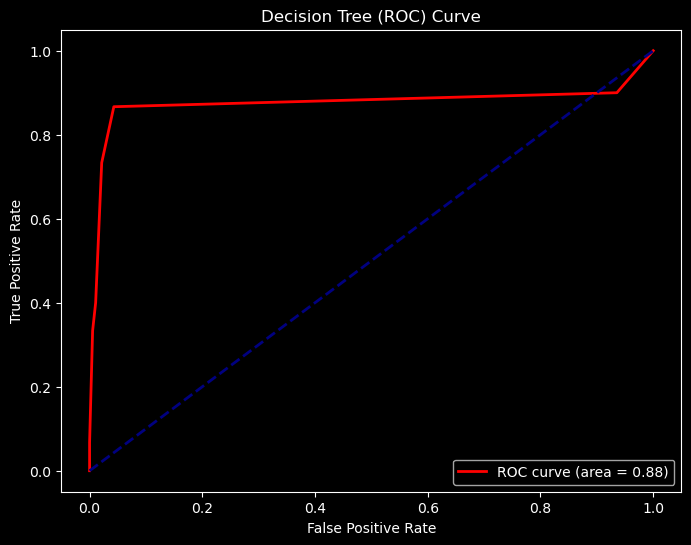

In [12]:
# Plot ROC curve
plot_ROC(fpr,tpr,final_roc_auc["DT"],"Decision Tree")

## SVM

In [13]:
# Scaling the data as specified in the lecture
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# SVM code with the scaled data


params_svm = {
    # I tuned C through multipile elimnations
    'C': range(80,100,5),
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'gamma': ['scale', 'auto'],
    "degree":range(0,10,1)

}

SVM = GridSearchCV(SVC(random_state=1, probability=True), param_grid=params_svm, cv=N_FOLDS, scoring='f1')
SVM.fit(X=X_train_scaled, y=y_train)
best_model_svm = SVM.best_estimator_
y_pred_svm = best_model_svm.predict(X_test_scaled)
y_predictions["SVM"] = y_pred_svm




In [15]:
# Calculate performance metrics
final_precision["SVM"] = precision_score(y_test, y_pred_svm)
final_recall["SVM"] = recall_score(y_test, y_pred_svm)
final_f1_score["SVM"] = f1_score(y_test, y_pred_svm)

# Calculate ROC AUC for SVM
y_roc_svm = best_model_svm.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_roc_svm)
final_roc_auc["SVM"] = auc(fpr_svm, tpr_svm)
plot_all_roc["SVM"] = [fpr_svm, tpr_svm, auc(fpr_svm, tpr_svm)]


In [16]:
print("\nSVM:")
print(f"precision: {final_precision['SVM']:0.2f}")
print(f"recall: {final_recall['SVM']:0.2f}")
print(f"f1_score: {final_f1_score['SVM']:0.2f}")
print(f"roc_auc: {final_roc_auc['SVM']:0.2f}")
print(f"Optimal hyperparameters:{SVM.best_params_}")



SVM:
precision: 0.96
recall: 0.83
f1_score: 0.89
roc_auc: 0.98
Optimal hyperparameters:{'C': 80, 'degree': 0, 'gamma': 'auto', 'kernel': 'rbf'}


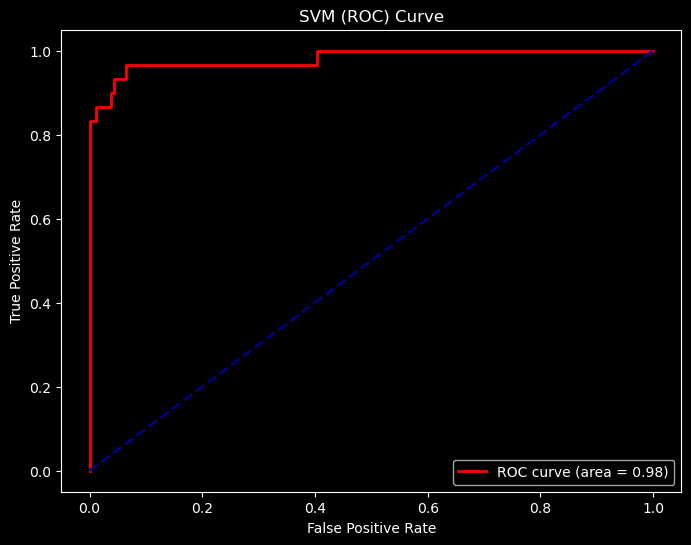

In [17]:
# Plot ROC curves
plot_ROC(fpr_svm, tpr_svm, final_roc_auc["SVM"], "SVM")

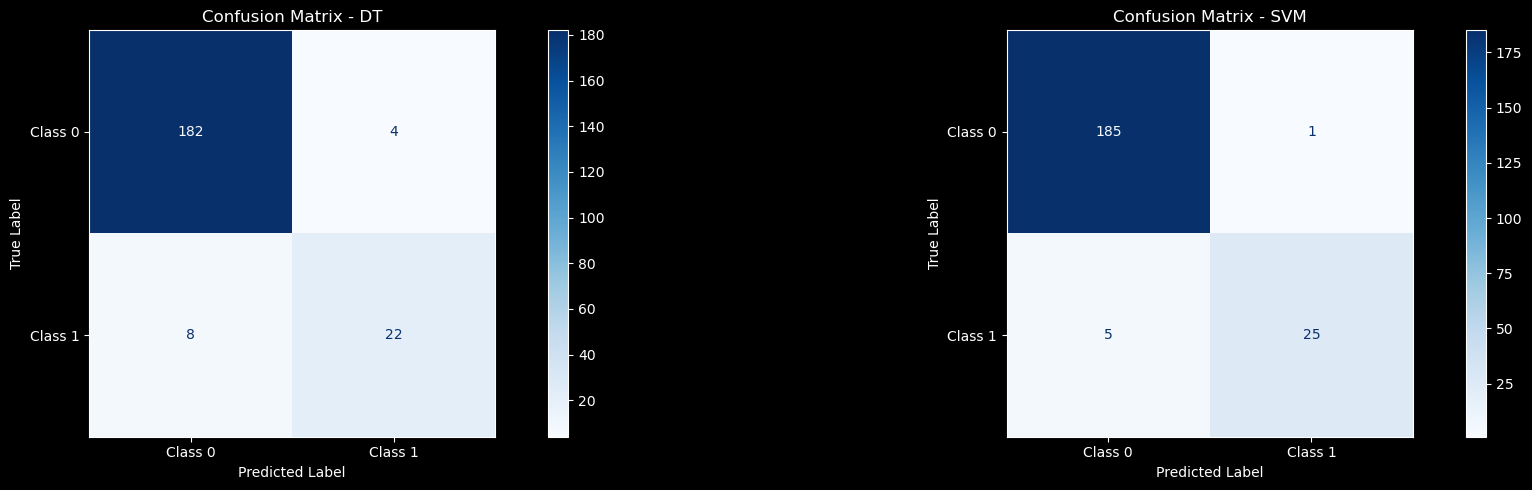

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for (model_name, predicted_labels), ax in zip(y_predictions.items(), axes.flatten()):
    cm = confusion_matrix(y_test, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']).plot(cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()


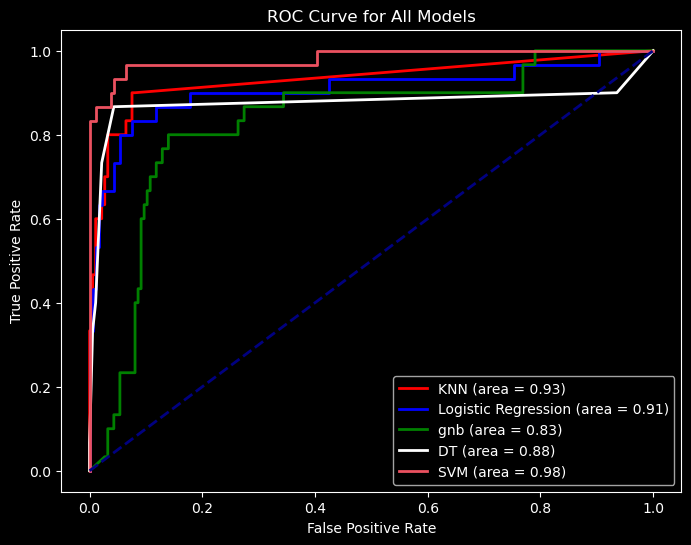

In [19]:
# Plotting ROC of all models
def plot_ROC_all(fpr, tpr, ROC, x, color):
    plt.plot(fpr, tpr, lw=2, label=f'{x} (area = {ROC:.2f})', color=color)

plt.figure(figsize=(8, 6))

# color for each model
colors = ['red', 'blue', 'green','white', '#EB5160']  

for i, (name, roc) in enumerate(plot_all_roc.items()):
    plot_ROC_all(roc[0], roc[1], roc[2], f"{name}", color=colors[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()


# Data Summary

In [20]:
summary_df = pd.concat([summary_df, pd.DataFrame([{
    'Model': 'Decision Tree',
    'Best Parameters':DT.best_params_,
    'ROC_AUC': f'{final_roc_auc["DT"]:0.2f}',
    'F1_score': f'{final_f1_score["DT"]:0.2f}',
    'Precision': f'{final_precision["DT"]:0.2f}',
    'Recall': f'{final_recall["DT"]:0.2f}'
}])], ignore_index=True)
summary_df = pd.concat([summary_df, pd.DataFrame([{
    'Model': 'SVM',
    'Best Parameters':SVM.best_params_,
    'ROC_AUC': f'{final_roc_auc["SVM"]:0.2f}',
    'F1_score': f'{final_f1_score["SVM"]:0.2f}',
    'Precision': f'{final_precision["SVM"]:0.2f}',
    'Recall': f'{final_recall["SVM"]:0.2f}'
}])], ignore_index=True)

In [21]:
summary_df

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
0,KNN,"{'n_neighbors': 5, 'weights': 'distance'}",0.93,0.73,0.8,0.67
1,Logistic Regeression,"{'C': 100, 'penalty': 'l2'}",0.91,0.61,0.88,0.47
2,Gaussian Bayes Classifier,No Parameters,0.83,0.51,0.38,0.8
3,Decision Tree,"{'criterion': 'entropy', 'max_depth': 7, 'max_...",0.88,0.79,0.85,0.73
4,SVM,"{'C': 80, 'degree': 0, 'gamma': 'auto', 'kerne...",0.98,0.89,0.96,0.83


In [22]:
import joblib

# Assuming model1, model2, and model3 are your trained models
joblib.dump(best_model_svm, 'SVM.pkl')
joblib.dump(best_model_DT, 'Decision Tree.pkl')


['Decision Tree.pkl']

## Choosing the best model

**Precision**: is that your model predicts more correctly but may miss some correct cases, so the more accurate the ones you say are correct are actually correct will give higher precision.<br>
**Recall**: is getting all the correct data even if some of them mayn't be correct as long as you find more correct it will give higher recall.

I will assume that the +ve class here is death(not recovered).
- So if want to focus on minimizing deaths and treating any one which may be suspect to death we use highest Recall(<b>capturing all positive cases</b>).<br>
- If this treatment is harmfull or not avaliable in huge quntity then we want to make sure that all who we predict will not recover will actually not recover although we may miss predict some casses as recovered but they wont recover then we will use highest Precision(<b>minimizing false positives</b>).

A good approach in an imbalanced datasheet is to use **F-1 score** as it takes into consideration precision and recall, or using **AUC of ROC curve**.



#### First I Will get the best model according to AUC of ROC curve
In my summary data frame I have AUC for all models as well as F1 Score 

In [23]:
summary_df['ROC_AUC'] = pd.to_numeric(summary_df['ROC_AUC'], errors='coerce')

summary_df[summary_df['ROC_AUC'] == summary_df['ROC_AUC'].max()]

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
4,SVM,"{'C': 80, 'degree': 0, 'gamma': 'auto', 'kerne...",0.98,0.89,0.96,0.83


#### Best model according to F1 score

In [24]:
summary_df['F1_score'] = pd.to_numeric(summary_df['F1_score'], errors='coerce')

summary_df[summary_df['F1_score'] == summary_df['F1_score'].max()]

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
4,SVM,"{'C': 80, 'degree': 0, 'gamma': 'auto', 'kerne...",0.98,0.89,0.96,0.83


#### Best model according to Precision

In [25]:
summary_df['Precision'] = pd.to_numeric(summary_df['Precision'], errors='coerce')

summary_df[summary_df['Precision'] == summary_df['Precision'].max()]

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
4,SVM,"{'C': 80, 'degree': 0, 'gamma': 'auto', 'kerne...",0.98,0.89,0.96,0.83


#### Best model according to Recall

In [26]:
summary_df['Recall'] = pd.to_numeric(summary_df['Recall'], errors='coerce')
summary_df.to_csv('summary_df.csv', index=False)
summary_df[summary_df['Recall'] == summary_df['Recall'].max()]

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
4,SVM,"{'C': 80, 'degree': 0, 'gamma': 'auto', 'kerne...",0.98,0.89,0.96,0.83


# The best Model for this specific task is **SVM**